# Time Series Forecasting

In [1]:
import numpy as np
import pandas as pd
import json
from matplotlib import pyplot as plt
from datetime import datetime
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.stattools import adfuller

regression_days_used = 60

In [8]:

coin_file = open("../../data/raw/coinmarketcap/historical_data.json")
coin_data = json.load(coin_file)

coin_data = pd.DataFrame(coin_data["Bitcoin"])

sentiment_data_df = pd.read_json("../../data/processed/reddit_summary_all.json", orient="index")

keyword_sentiment_data = sentiment_data_df["keyword_based_sentiment"].apply(pd.Series)

Bitcoin_specific_sentiment = keyword_sentiment_data["BTC"].apply(pd.Series)[["count","sentiment"]].dropna()

coin_data["timestamp"] = pd.to_datetime(coin_data["timestamp"]).dt.date

Bitcoin_specific_sentiment.reset_index(inplace=True)
Bitcoin_specific_sentiment.rename(columns = {"index": 'timestamp'}, inplace=True)
Bitcoin_specific_sentiment["timestamp"] = pd.to_datetime(Bitcoin_specific_sentiment["timestamp"]).dt.date


merged_data = pd.merge(left=coin_data, right=Bitcoin_specific_sentiment, how='left', left_on='timestamp', right_on='timestamp').dropna()

merged_data.index = pd.DatetimeIndex(merged_data["timestamp"]).to_period("d")
merged_data.drop(labels = "timestamp", axis = 1, inplace=True)
#merged_data.drop(labels = ["high", "low", "close", "volume", "marketCap", "count"], axis=1, inplace=True)
merged_data.drop(labels = ["high", "low", "close", "volume", "marketCap"], axis=1, inplace=True)
merged_data.head(5)

,open,count,sentiment
timestamp,,,
2022-02-22,47292.338598,15.0,0.319
2022-02-23,48881.232286,31.0,0.596
2022-02-24,47472.202298,23.0,-1.202
2022-02-25,49099.205024,44.0,1.397
2022-02-26,49853.946198,24.0,1.839


In [9]:
coint_johansen(merged_data, -1, 1).eig

array([0.33660554, 0.16633899, 0.00471072])

In [21]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")    

df_difference = merged_data.diff().diff().diff().dropna()
df_difference = df_difference[-regression_days_used:]
for name, column in df_difference.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "open" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -3.2847
 No. Lags Chosen       = 9
 Critical value 1%     = -3.809
 Critical value 5%     = -3.022
 Critical value 10%    = -2.651
 => P-Value = 0.0156. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "count" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.8614
 No. Lags Chosen       = 9
 Critical value 1%     = -3.809
 Critical value 5%     = -3.022
 Critical value 10%    = -2.651
 => P-Value = 0.05. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "sentiment" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level 

In [15]:
#creating the train and validation set

num_obs = 3
train = df_difference[:-num_obs]

model = VAR(train)

suggested_order = model.select_order(maxlags=4)
suggested_order.summary()

,AIC,BIC,FPE,HQIC
0,26.66,26.81,3.793e+11,26.70
1,25.64,26.23*,1.380e+11,25.80
2,25.54,26.57,1.301e+11,25.81
3,25.34*,26.81,1.191e+11*,25.73*
4,25.58,27.50,1.905e+11,26.09


In [16]:
results = model.fit(3)
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 30, Mar, 2022
Time:                     16:08:01
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    26.6656
Nobs:                     25.0000    HQIC:                   25.6086
Log likelihood:          -391.457    FPE:                1.01655e+11
AIC:                      25.2030    Det(Omega_mle):     3.70462e+10
--------------------------------------------------------------------
Results for equation open
                  coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------
const              -20.700076       578.458831           -0.036           0.971
L1.open             -0.594659         0.243667           -2.440           0.015
L1.count           -26.637095        25.015621           -1.065  

In [17]:
from statsmodels.stats.stattools import durbin_watson

out = durbin_watson(results.resid)


for col, val in zip(train.columns, out):
    print(col, ':', round(val, 2))


open : 1.85
count : 1.83
sentiment : 2.39


In [18]:
lag_order = results.k_ar

print("LAG ORDER IS: {} ".format(lag_order))

forecasting_input = df_difference.values[-lag_order:]


fc = results.forecast(forecasting_input, steps=num_obs)

print(df_difference.index[-1])

idx = pd.date_range(str(df_difference.index[-1]), periods=num_obs, freq='D')

df_forecast = pd.DataFrame(fc, index=idx, columns=df_difference.columns + '_2d')

def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

df_results = invert_transformation(merged_data[-regression_days_used:], df_forecast, second_diff=True)    
df_results.drop(["open_2d", "open_1d", "sentiment_1d", "sentiment_2d"], axis=1, inplace=True)
print(df_results)

LAG ORDER IS: 3 
2022-03-26
              count_2d  open_forecast   count_1d  count_forecast  \
2022-03-26  100.761694   55413.856996 -17.238306      152.761694   
2022-03-27   -7.461026   53009.645188 -24.699332      128.062362   
2022-03-28  -25.208365   53983.832842 -49.907696       78.154666   

            sentiment_forecast  
2022-03-26           14.291722  
2022-03-27           13.158157  
2022-03-28            4.218879  


In [19]:
print(merged_data[-num_obs:])

forecasts = df_results[["open_forecast", "sentiment_forecast"]]
print(forecasts)

                    open  count  sentiment
timestamp                                 
2022-03-24  53864.050890  296.0     21.833
2022-03-25  55047.920399  288.0     19.408
2022-03-26  55328.665889  170.0     15.909
            open_forecast  sentiment_forecast
2022-03-26   55413.856996           14.291722
2022-03-27   53009.645188           13.158157
2022-03-28   53983.832842            4.218879


2022-03-26    55413.856996
2022-03-27    53009.645188
2022-03-28    53983.832842
Freq: D, Name: open_forecast, dtype: float64


<AxesSubplot:xlabel='timestamp'>

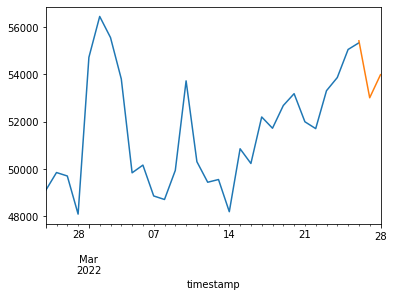

In [20]:

forecast_data = forecasts["open_forecast"]
actual_data = merged_data[-30:]["open"]

print(forecast_data)

actual_data.plot(y="open")
forecast_data.plot(y="open_forecast")